# Importing dependencies

In [3]:
!pip install pyLDAvis

In [4]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline 
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim import corpora
import nltk
nltk.download('punkt')
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data loading

In [5]:
#Saved it in GDrive to avoid uploading manually each time
!gdown https://drive.google.com/uc?id=157toQjAZjBz8LxBkjaKVdsS7OO_GonvJ

Downloading...
From: https://drive.google.com/uc?id=157toQjAZjBz8LxBkjaKVdsS7OO_GonvJ
To: /content/Reviews.csv
301MB [00:01, 206MB/s]


In [6]:
data = pd.read_csv(r'/content/Reviews.csv', index_col='Id')
data.sample(5)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
237030,B005JTMFQO,A3MFGQNJOZ0U11,Val,1,2,1,1329091200,$11.94 + $19.99 shipping,$11.94 + $19.99 shipping for a salmon burger? ...
436727,B008O3G2GG,A20MMOYFA8BTNR,"McCarth ""aka sLiM sHaDy""",0,2,1,1320537600,Pointless dog treat,Are we seriously supposed to stand there for h...
531952,B005K4Q34S,AVUO19P8ZQHLV,Amber Tro,0,0,4,1322179200,Good product,This is instant cappuccino. It is pretty tast...
516887,B001SIXXWU,APW97LVMKW10K,brian,0,0,5,1316822400,great product,this is the best jerky. original is better the...
373008,B00124TUTK,AXRTBGDT567Z1,Lana,1,2,1,1340582400,"CONTAINS TITANIUM DIOXIDE, TOXIC and CARCINOGEN!",It contains TITANUIM DIOXIDE that is dangerous...


# Exploratory data analysis and data preparation


In [7]:
print(f"No. of unique products: {data['ProductId'].nunique()}")
print(f"No. of unique users:\t{data['UserId'].nunique()}")

No. of unique products: 74258
No. of unique users:	256059


In [8]:
def preprocess(data, threshold=0.5):
    
    """
    preprocess processes the incoming data before doing any text analysis.
    
    The following things are done:
    1. Calculating the helpfulness of each review
    2. Filtering the reviews which are greater than the given threshold
    3. Plotting the distribution of helpfulness of reviews to understand the proportion of reviews which are helpful
    4.Combining a new dataframe 'text' with summary and body text of the reviews
    5. Adding the score of the reviews in the 'text' dataframe
    6. When the reviews are NULL, fill them with blank space
    7. Return 'text' for text analysis

    """
    
    data['Helpfulness'] = data.HelpfulnessNumerator/data.HelpfulnessDenominator
    data.Helpfulness.fillna(0, inplace=True)
    helpful = data[data.Helpfulness>threshold]
    sns.histplot(data[data['Helpfulness']<=1].Helpfulness, color='seagreen')
    text = pd.DataFrame(helpful['Summary']+" " +helpful['Text'])
    text['Score'] = helpful.Score
    text[0].fillna(' ', inplace=True)

    return text

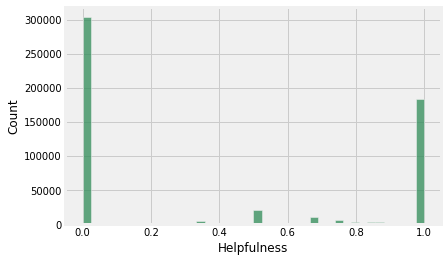

In [9]:
text = preprocess(data, threshold=0.5)

`Observations`

* Majority reviews are not helpful. We are only analysing reviews where the helpful quotient is atleast > 0.5, i.e. better than random

In [10]:
print(f"Percentage of reviews taken for text analysis: {round(text.shape[0]/data.shape[0]*100,2)}%")

Percentage of reviews taken for text analysis: 39.87%


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


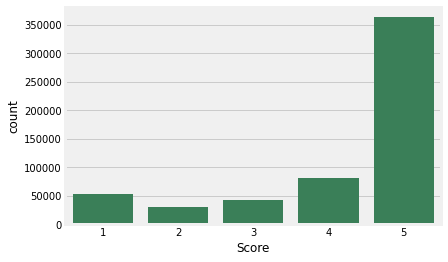

In [11]:
sns.countplot(data['Score'], color='seagreen')

``

In [12]:
def text_restricted_rating(ratings):

    """
    
    This function returns reviews with only certain ratings

    """

    return text[text.Score.isin(ratings)]

# Question answering in different categories of reviews

In [72]:
def answer(question, ratings=[2]):

    """
    answer is used to find reviews based on a question, like whether people have talked about excess sugar in some products, and if yes, which products

    The following things are done:
    1. Filter the text based on the specific ratings you want to search
    2. Convert the text into features based on TFIDF using 500 features and SVD using 100 components
    3. Transform the question using TFIDF and SVD
    4. Find the nearest matching answer and its product
    5. If no answer is found, also mention that
    
    """

    text = text_restricted_rating(ratings)
    tfidf=TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS.union('href', 'br'), max_features=500)
    tfidf.fit(text[0])
    words = tfidf.transform(text[0])
    words = pd.DataFrame(words.A, columns=tfidf.get_feature_names())
    tsvd = TruncatedSVD(n_components=100)
    svd_mat=tsvd.fit_transform(words)

    try:
        q1_f = tfidf.transform([question])
        q1_formatted = tsvd.transform(q1_f)
        d = pairwise_distances(X = q1_formatted, Y=svd_mat, metric='cosine')
        pos = np.argmin(d)
        answer = text.iloc[pos][0]
        prod=[]
        ans=[]
        for product, line in zip(data.ProductId, text[0]):
            if answer in str(line):
                prod.append(product)
                ans.append(text[0])
        return prod,ans 
    except:
        return "No answer found", ""

In [73]:
q1 = "Sugary drinks"

In [75]:
product, ans = answer(q1)
for p,r in zip(product, ans):
    print(f"Product:{p}, \n Review: {r}")

Product:B000FDKQCO, 
 Review: Id
4         Cough Medicine If you are looking for the secr...
111       Low Carb Angel Food Puffs I was diappointed in...
132       Not for me I must be a bit of a wuss, because ...
147       BROKEN BOTTLE BOTTOMS! The SALSA smelled delic...
259       Disappointed! This product has a strong after-...
                                ...                        
568204    It's mushy & tasteless. Contains skin, cartila...
568339    Poor Quality I used to eat these when I was a ...
568361    Not too impressed by non-typical Earl Grey fla...
568388    good idea but messy this ia a good idea; howev...
568417    not what I ordered When I ordered this chutney...
Name: 0, Length: 9972, dtype: object
Product:B001L1KH6Y, 
 Review: Id
4         Cough Medicine If you are looking for the secr...
111       Low Carb Angel Food Puffs I was diappointed in...
132       Not for me I must be a bit of a wuss, because ...
147       BROKEN BOTTLE BOTTOMS! The SALSA smelled delic.

# Word embeddings selectable in different review ratings

In [16]:
def similar_words(target, k_similar_words=10, ratings=[2]):

    """

    similar_words finds k-similar words to a given word in selected ratings

    The following things are done:
    1. Filter the text based on the specific ratings you want to search
    2. Convert the text into features based on TFIDF using 500 features and SVD using 100 components
    3. Find the word in the vocabulary
    4. For that word, create an array with TFIDF scores against all words
    5. Calculate pairwise distance between the target word and all the words in the vocabulary
    6. Print out the k-similar words

    """

    text = text_restricted_rating(ratings)
    tfidf=TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS.union('href', 'br'), max_features=500)
    words = tfidf.fit_transform(text[0])
    words = pd.DataFrame(words.A, columns=tfidf.get_feature_names())
    tsvd_wv  =TruncatedSVD(n_components=200)
    word_mat = tsvd_wv.fit_transform(words.T)
    tfidf.vocabulary_[target]
    wd_query_array = word_mat[tfidf.vocabulary_[target],:].reshape(1,-1)
    wd_d = pairwise_distances(X=word_mat,Y=wd_query_array)
    k_sim_words_index=np.argsort(wd_d.flatten())[1:k_similar_words+1]
    id2word = {v:k for k,v in tfidf.vocabulary_.items()}
    print(f'{k_similar_words} similar words to {target}:', [id2word[x] for x in k_sim_words_index],f'in ratings:{ratings}')

In [17]:
similar_words('taste',5, [1])

5 similar words to taste: ['chemical', 'strong', 'enjoy', 'worse', 'trying'] in ratings:[1]


# Wordblobs

In [18]:
def wordblob1():

    """
    wordblob1 prints the wordblob for products reviews with 5 star ratings after removing trivial words

    """
    
    score_1 = text[text.Score==1]
    scorer1=[]
    for line in score_1[0]:
        scorer1.append(line)
    scorer1_blob="".join(scorer1)
    scorer1s=WordCloud(stopwords=ENGLISH_STOP_WORDS.union(['href', 'br','like','buy','product','did','Amazon','just']), background_color='white').generate(scorer1_blob)

    plt.figure(figsize=(15,10))
    plt.title('Wordcloud for rating 1', fontsize=14)
    plt.imshow(scorer1s,interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [19]:
def wordblob5():

    """

    wordblob5 prints the wordblob for products reviews with 5 star ratings after removing trivial words

    """

    score_5 = text[text.Score==5]
    scorer5=[]
    for line in score_5[0]:
        scorer5.append(line)
    scorer5_blob="".join(scorer5)
    scorer5s=WordCloud(stopwords=ENGLISH_STOP_WORDS.union(['href','br','like','make','Amazon','love','just','use','good','great','best']), background_color='white').generate(scorer5_blob)

    plt.figure(figsize=(15,10))
    plt.title('Wordcloud for rating 5', fontsize=14)
    plt.imshow(scorer5s,interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [20]:
def wordblob_general(ratings=[2]):

    """

    wordblob_general prints the wordblob for products reviews with ratings as per user wishes, after removing trivial words

    """

    score = text_restricted_rating(ratings)
    scorer=[]
    for line in score[0]:
        scorer.append(line)
    scorer_blob="".join(scorer)
    scorers=WordCloud(stopwords=ENGLISH_STOP_WORDS.union(['href','br','like','make','Amazon','love','just','use','good','great','best']), background_color='white').generate(scorer_blob)

    plt.figure(figsize=(15,10))
    plt.title(f'Wordcloud for rating {ratings}', fontsize=14)
    plt.imshow(scorers,interpolation='bilinear')
    plt.axis('off')
    plt.show()

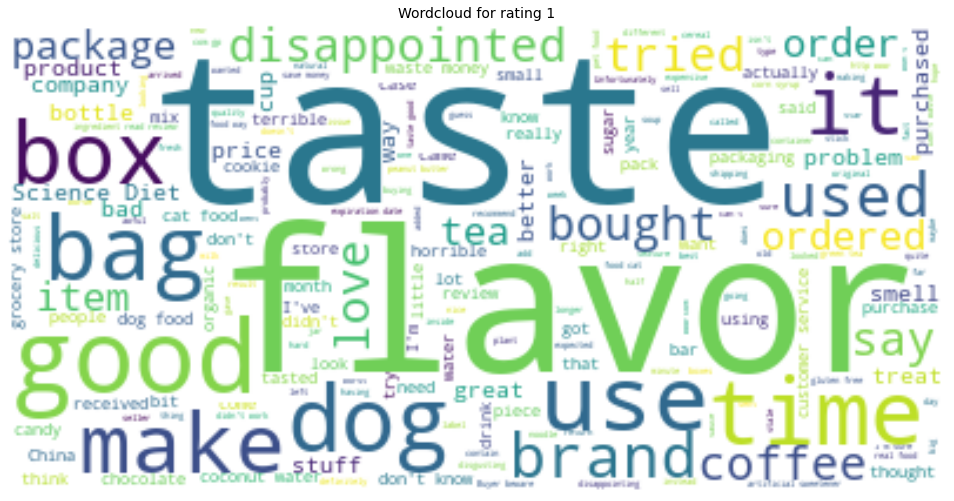

In [21]:
wordblob1()

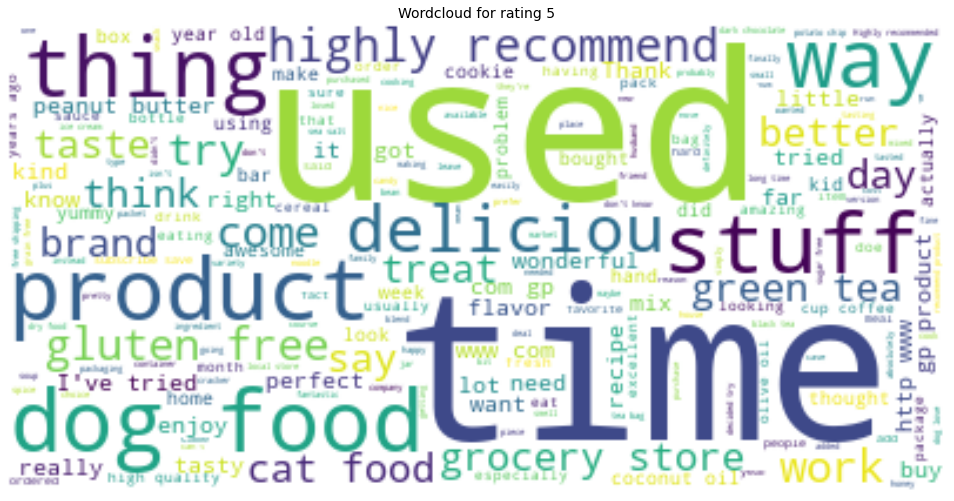

In [22]:
wordblob5()

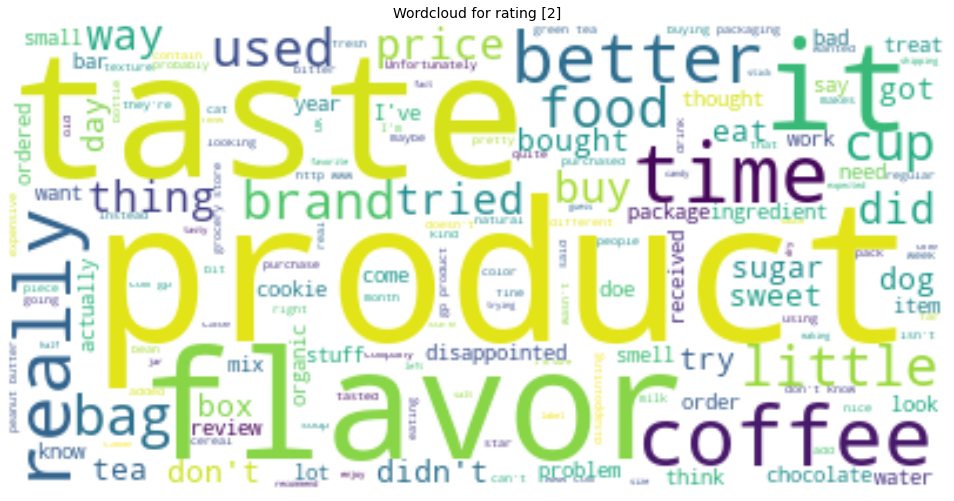

In [23]:
wordblob_general([2])

# Topic modelling in for specific rating categories in reviews

Reference: Prateek Joshi, An NLP Approach to Mining Online Reviews using Topic Modeling(https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/)

In [28]:
# Importing them here because otherwise they wreak havoc in the notebook
import pyLDAvis
import pyLDAvis.gensim_models

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [29]:
ratings=[2]
no_of_topics = 2

In [30]:
text = text_restricted_rating(ratings)
sents = [line for line in text[0]]
sents="".join([str(x) for x in sents])
sent = sent_tokenize(sents)
sent = [word_tokenize(s) for s in sent]
p = PorterStemmer()
stemmed_words = [[p.stem(word) for word in words if word not in ENGLISH_STOP_WORDS] for words in sent]

In [34]:
dic = corpora.Dictionary(stemmed_words)
doc_matrix = [dic.doc2bow(word) for word in stemmed_words]
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=doc_matrix, id2word=dic, num_topics=no_of_topics, random_state=123, chunksize=5, passes=1)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_matrix, dic)
vis

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

PreparedData(topic_coordinates=             x    y  topics  cluster      Freq
topic                                         
1      0.22897  0.0       1        1  67.51741
0     -0.22897  0.0       2        1  32.48259, topic_info=        Term          Freq         Total Category  logprob  loglift
119        >  15759.000000  15759.000000  Default  30.0000  30.0000
118        <  15757.000000  15757.000000  Default  29.0000  29.0000
117        /  14966.000000  14966.000000  Default  28.0000  28.0000
121       br  14795.000000  14795.000000  Default  27.0000  27.0000
1          I  36091.000000  36091.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
30       the   1832.817015   5796.082655   Topic2  -4.9034  -0.0269
0          .   2946.499972  45756.921481   Topic2  -4.4287  -1.6183
111      box    981.510780   2262.684652   Topic2  -5.5279   0.2893
161  product    788.916086   4620.837912   Topic2  -5.7464  -0.6432
55         -    746.630262   2152.185444   Topic2  -5.8015   0.0658

[128 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
48        1  0.997639      !
48        2  0.002367      !
308       1  0.004314      $
308       2  0.996533      $
54        1  0.000202     ''
...     ...       ...    ...
307       2  0.000535   want
301       1  0.012916  white
301       2  0.988053  white
69        1  0.998972   work
69        2  0.001004   work

[188 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

# Sentiment analysis

In [24]:
def sentiment(ratings=[2]):

    """
    This function calculates the sentiment for given ratings

    Sentiment = Polarity * Objectivity
              = Polarity * (1-Subjectivity)

    """

    text = text_restricted_rating(ratings)
    sentiments=pd.Series([])
    for i in range(text.shape[0]):
        t=TextBlob(text[0].iloc[i])
        sentiments[i]=float(t.sentiment[0]*(1-t.sentiment[1]))
    print(f'Sentiment for ratings: {ratings} = ', round(np.sum(sentiments)/sentiments.shape[0],2))

In [25]:
sentiment()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  if sys.path[0] == '':


Sentiment for ratings: [2] =  0.04


`Observation`

* The sentiment is almost neutral at review rating 2

# Predicting rating based on review

In [26]:
def MLprocess(stemmed_words):

    """
    process receives the stemmed words and returns the training and test datasets for modelling

    The following things are done:
    1. Instantiates the TFIDF object
    2. Creates feature matrix after fitting and transforming TFIDF
    3. Creates the training and testing partitions in the data with test size as 20%
    4. Returns the training and testing X and y

    """
    tfidf=TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS.union('href','br'), max_features=500)
    words = tfidf.fit_transform(text[0])
    X_train, X_test, y_train, y_test = train_test_split(words, text.Score, test_size = 0.2, random_state=123)
    return X_train, X_test, y_train, y_test

In [31]:
X_train, X_test, y_train, y_test = MLprocess(stemmed_words)

In [32]:
def evaluator(model):

    """
    evaluator trains models and returns the accuracy of each model on the testing set

    """
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [53]:
nb_acc = evaluator(BernoulliNB())
#rf_acc = evaluator(RandomForestClassifier(random_state=123))    STOPPED EXECUTION DUE TO PAUCITY OF TIME
print(f'Accuracy for Naive Bayes:{nb_acc}')
#print(f'Accuracy for Random Forest:{rf_acc}')    STOPPED EXECUTION DUE TO PAUCITY OF TIME

Accuracy for Naive Bayes:1.0
